In [98]:
%pip install memory_profiler

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [99]:
import time
import re
import memory_profiler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
import fitz  # PyMuPDF
import docx
import csv
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELLS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELLS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [100]:
def convert_to_text(file_path):
    _, file_extension = os.path.splitext(file_path)
    text = ""

    if file_extension.lower() == ".pdf":
        with fitz.open(file_path) as pdf:
            for page in pdf:
                text += page.get_text()

    elif file_extension.lower() == ".docx":
        doc = docx.Document(file_path)
        for paragraph in doc.paragraphs:
            text += paragraph.text + "\n"

    elif file_extension.lower() == ".txt":
        with open(file_path, "r", encoding="latin") as txt_file:
            text = txt_file.read()

    elif file_extension.lower() == ".csv":
        with open(file_path, "r", encoding="utf-8") as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                text += ",".join(row) + "\n"

    else:
        print("Unsupported file format:", file_extension)
        return None

    return text.strip()



In [101]:
def preprocess_text(text):
    text=re.sub(r'[^\w\s]', '', text)
 
    tokens = word_tokenize(text)
    
   
   
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token.lower() for token in tokens if token not in stop_words]
    
    # Join tokens back into a string
    preprocessed_text = " ".join(filtered_tokens)
    
    return preprocessed_text

In [102]:
def batch_text(text, batch_size):
    # Split text into batches of specified size
    batches = [text[i:i+batch_size] for i in range(0, len(text), batch_size)]
    return batches


In [103]:
def preprocess_strong_suffix(shift, bpos, pat, m):
    i = m
    j = m + 1
    bpos[i] = j

    while i > 0:
        while j <= m and pat[i - 1] != pat[j - 1]:
            if shift[j] == 0:
                shift[j] = j - i
            j = bpos[j]
        i -= 1
        j -= 1
        bpos[i] = j

def preprocess_case2(shift, bpos, m):
    j = bpos[0]
    for i in range(m + 1):
        if shift[i] == 0:
            shift[i] = j
        if i == j:
            j = bpos[j]

def bm_string_match(text, pattern):
    matches = []
    s = 0
    m = len(pattern)
    n = len(text)

    bpos = [0] * (m + 1)
    shift = [0] * (m + 1)

    preprocess_strong_suffix(shift, bpos, pattern, m)
    preprocess_case2(shift, bpos, m)

    while s <= n - m:
        j = m - 1
        while j >= 0 and pattern[j] == text[s + j]:
            j -= 1
        if j < 0:
            matches.append(s)
            s += shift[0]
        else:
            s += shift[j + 1]
    
    return matches


In [104]:
def compute_prefix_function(pattern):
    prefix = [0] * len(pattern)
    j = 0
    for i in range(1, len(pattern)):
        while j > 0 and pattern[j] != pattern[i]:
            j = prefix[j - 1]
        if pattern[j] == pattern[i]:
            j += 1
        prefix[i] = j
    return prefix

def kmp_string_match(text, pattern):
    prefix = compute_prefix_function(pattern)
    j = 0
    positions = []  # to store the positions of the pattern
    for i in range(len(text)):
        while j > 0 and text[i] != pattern[j]:
            j = prefix[j - 1]
        if text[i] == pattern[j]:
            j += 1
        if j == len(pattern):
            positions.append(i - (j - 1))  # add the position to the list
            j = prefix[j - 1]  # prepare for the next match
    return positions  # return the list of positions



In [105]:
def rabinkarp_string_match(txt, pat, q=101):
    M = len(pat)
    N = len(txt)
    d = 256  # Number of characters in the input alphabet
    p = 0    # Hash value for pattern
    t = 0    # Hash value for text
    h = 1

    # Calculate the hash value of pattern and the first window of text
    for i in range(M):
        p = (d * p + ord(pat[i])) % q
        t = (d * t + ord(txt[i])) % q

    # Calculate h: pow(d, M-1) % q
    for i in range(M - 1):
        h = (h * d) % q

    indexes = []

    # Slide the pattern over the text
    for i in range(N - M + 1):
        # Check if hash values match, and then compare characters
        if p == t:
            match = True
            for j in range(M):
                if txt[i + j] != pat[j]:
                    match = False
                    break
            if match:
                indexes.append(i)
                

        # Calculate hash value for the next window of text
        if i < N - M:
            t = (d * (t - ord(txt[i]) * h) + ord(txt[i + M])) % q

            # Ensure positive hash value
            if t < 0:
                t += q

    return indexes


In [106]:
def brute_force(text, pattern):
    n = len(text)
    m = len(pattern)
    indices = []
    for i in range(n - m + 1):
        j = 0
        while j < m and text[i + j] == pattern[j]:
            j += 1
        if j == m:
            indices.append(i)  # pattern found at index i
    return indices 

In [107]:
def search_pattern_in_batch(batch, pattern, match):
    return match(batch, pattern)


In [108]:
def measure_accuracy(total_expected_patterns, total_found_patterns):
    if total_expected_patterns == 0:
        return 0.0
    return min(total_found_patterns / total_expected_patterns, 1.0)


In [109]:
def measure_performance(algorithm, text, pattern, expected):
    start_time = time.time()
    memory_usage_before = memory_usage()[0]
    
    # Run the algorithm
    matches = algorithm(text, pattern)
    
    end_time = time.time()
    memory_usage_after = memory_usage()[0]

    accuracy_score=measure_accuracy(expected,len(matches))
    
    time_taken = end_time - start_time
    memory_used = memory_usage_after - memory_usage_before
    
    return time_taken*1000, memory_used,accuracy_score

In [110]:
data = pd.read_csv("C:/Users/DELLS/Documents/Final Year Project/data1.csv")
fileSizes=[]
texts=[]
preprocessing_times=[]
preprocessing_memorys=[]


bm_execution_times = []
bm_memory_usages = []
bm_accuracy_scores = []

bm_execution_times_pre = []
bm_memory_usages_pre = []
bm_accuracy_scores_pre = []

kmp_execution_times = []
kmp_memory_usages = []
kmp_accuracy_scores = []

kmp_execution_times_pre = []
kmp_memory_usages_pre = []
kmp_accuracy_scores_pre = []

rk_execution_times = []
rk_memory_usages = []
rk_accuracy_scores = []

rk_execution_times_pre = []
rk_memory_usages_pre = []
rk_accuracy_scores_pre = []

bf_execution_times = []
bf_memory_usages = []
bf_accuracy_scores = []

bf_execution_times_pre = []
bf_memory_usages_pre = []
bf_accuracy_scores_pre = []



for _,row in data.iterrows():
    size=os.path.getsize(row['File'])
    fileSizes.append(size)

    
    

    text = convert_to_text(row['File'])*10
    texts.append(text)
    pattern = row['Pattern']
    expected = row['Expected']*10

    start_time = time.time()
    memory_usage_before = memory_usage()[0]    
    preprocessed_text=preprocess_text(text)
    lowercase_pattern=preprocess_text(pattern)   
    end_time = time.time()
    memory_usage_after = memory_usage()[0]
    preprocessing_time = end_time - start_time
    preprocessing_memory = memory_usage_after - memory_usage_before
    preprocessing_times.append(preprocessing_time)
    preprocessing_memorys.append(preprocessing_memory)

   

    time_taken, memory_used, accuracy_score = measure_performance(bm_string_match, text, pattern, expected)
    time_taken_pre, memory_used_pre, accuracy_score_pre = measure_performance(bm_string_match, preprocessed_text, lowercase_pattern, expected)
    bm_execution_times.append(time_taken)
    bm_execution_times_pre.append(time_taken_pre)
    bm_memory_usages.append(memory_used)
    bm_memory_usages_pre.append(memory_used_pre)
    bm_accuracy_scores.append(accuracy_score)
    bm_accuracy_scores_pre.append(accuracy_score_pre)

    time_taken, memory_used, accuracy_score = measure_performance(kmp_string_match, text, pattern, expected)
    time_taken_pre, memory_used_pre, accuracy_score_pre = measure_performance(bm_string_match, preprocessed_text, lowercase_pattern, expected)
    kmp_execution_times.append(time_taken)
    kmp_execution_times_pre.append(time_taken_pre)
    kmp_memory_usages.append(memory_used)
    kmp_memory_usages_pre.append(memory_used_pre)
    kmp_accuracy_scores.append(accuracy_score)
    kmp_accuracy_scores_pre.append(accuracy_score_pre)

    time_taken, memory_used, accuracy_score = measure_performance(rabinkarp_string_match, text, pattern, expected)
    time_taken_pre, memory_used_pre, accuracy_score_pre = measure_performance(bm_string_match,preprocessed_text,lowercase_pattern, expected)
    rk_execution_times.append(time_taken)
    rk_execution_times_pre.append(time_taken_pre)
    rk_memory_usages.append(memory_used)
    rk_memory_usages_pre.append(memory_used_pre)
    rk_accuracy_scores.append(accuracy_score)
    rk_accuracy_scores_pre.append(accuracy_score_pre)

    time_taken, memory_used, accuracy_score = measure_performance(brute_force, text, pattern, expected)
    time_taken_pre, memory_used_pre, accuracy_score_pre = measure_performance(bm_string_match,preprocessed_text, lowercase_pattern, expected)
    bf_execution_times.append(time_taken)
    bf_execution_times_pre.append(time_taken_pre)
    bf_memory_usages.append(memory_used)
    bf_memory_usages_pre.append(memory_used_pre)
    bf_accuracy_scores.append(accuracy_score)
    bf_accuracy_scores_pre.append(accuracy_score_pre)

    

    







    


data['File_size']=fileSizes
data['Text']=texts
data['Preprocessing_times']=preprocessing_times
data['Preprocessing_memory']=preprocessing_memorys

data['BM preprocessesed Time']=bm_execution_times_pre
data['BM preprocessesed Memory']=bm_memory_usages_pre
data['BM Time']=bm_execution_times
data['BM Memory']=bm_memory_usages
data['BM prepocessed Accuracy']=bm_accuracy_scores_pre
data['BM Accuracy']=bm_accuracy_scores

data['KMP preprocessesed Time']=kmp_execution_times_pre
data['KMP preprocessesed Memory']=kmp_memory_usages_pre
data['KMP Time']=kmp_execution_times
data['KMP Memory']=kmp_memory_usages
data['KMP prepocessed Accuracy']=kmp_accuracy_scores_pre
data['KMP Accuracy']=kmp_accuracy_scores

data['RK preprocessesed Time']=rk_execution_times_pre
data['RK preprocessesed Memory']=rk_memory_usages_pre
data['RK Time']=rk_execution_times
data['RK Memory']=rk_memory_usages
data['RK prepocessed Accuracy']=rk_accuracy_scores_pre
data['RK Accuracy']=rk_accuracy_scores

data['BF preprocessesed Time']=bf_execution_times_pre
data['BF preprocessesed Memory']=bf_memory_usages_pre
data['BF Time']=bf_execution_times
data['BF Memory']=bf_memory_usages
data['BF prepocessed Accuracy']=bf_accuracy_scores_pre
data['BF Accuracy']=bf_accuracy_scores

    


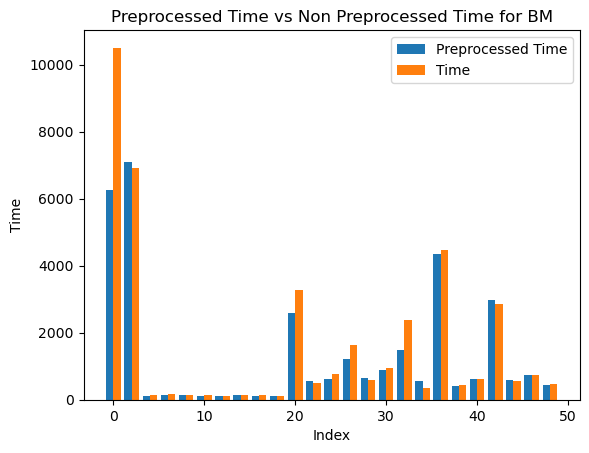

In [111]:

bin_width=0.8
plt.bar(data.index*2-bin_width/2,data['BM preprocessesed Time'], label='Preprocessed Time')
plt.bar(data.index*2+bin_width/2,data['BM Time'],label="Time")

plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Preprocessed Time vs Non Preprocessed Time for BM')

plt.legend()
plt.show()

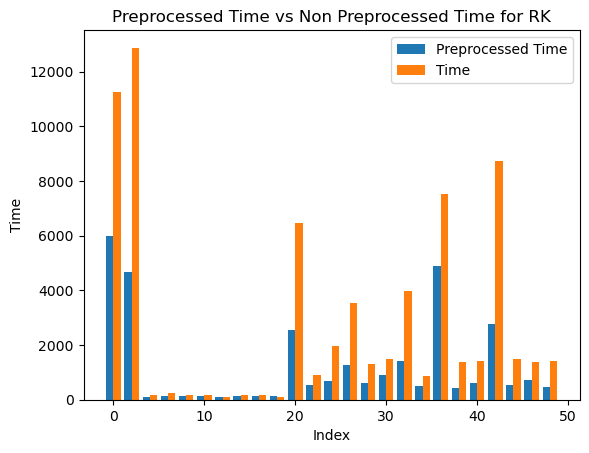

In [112]:

bin_width=0.8
plt.bar(data.index*2-bin_width/2,data['RK preprocessesed Time'], label='Preprocessed Time')
plt.bar(data.index*2+bin_width/2,data['RK Time'],label="Time")

plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Preprocessed Time vs Non Preprocessed Time for RK')

plt.legend()
plt.show()

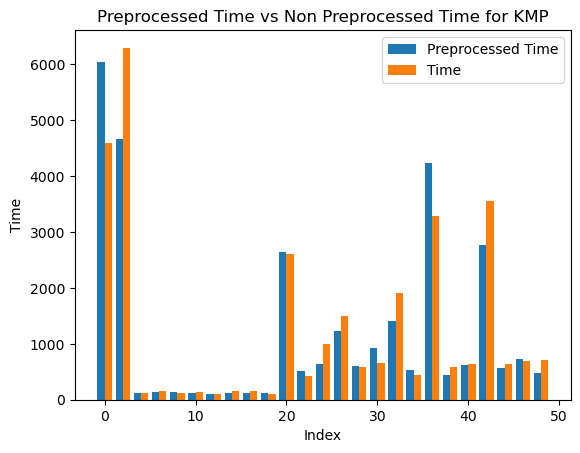

In [113]:

bin_width=0.8
plt.bar(data.index*2-bin_width/2,data['KMP preprocessesed Time'], label='Preprocessed Time')
plt.bar(data.index*2+bin_width/2,data['KMP Time'],label="Time")

plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Preprocessed Time vs Non Preprocessed Time for KMP')

plt.legend()
plt.show()

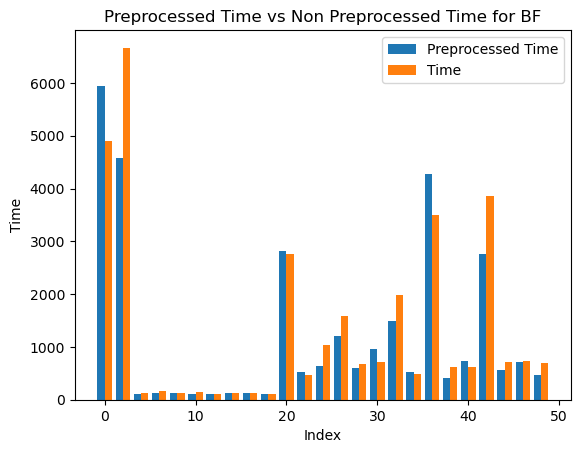

In [114]:

bin_width=0.8
plt.bar(data.index*2-bin_width/2,data['BF preprocessesed Time'], label='Preprocessed Time')
plt.bar(data.index*2+bin_width/2,data['BF Time'],label="Time")

plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Preprocessed Time vs Non Preprocessed Time for BF')

plt.legend()
plt.show()

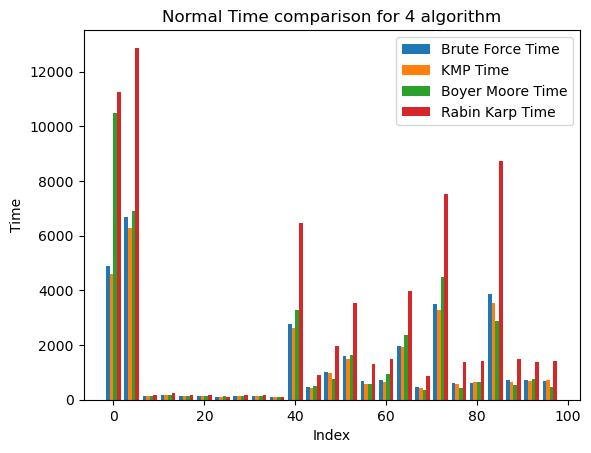

In [115]:
bin_width=0.8
plt.bar(data.index*4-3 *bin_width/2,data['BF Time'], label='Brute Force Time')
plt.bar(data.index*4-bin_width/2,data['KMP Time'], label='KMP Time')
plt.bar(data.index*4+bin_width/2,data['BM Time'],label="Boyer Moore Time")
plt.bar(data.index*4+3*bin_width/2,data['RK Time'],label="Rabin Karp Time")

plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Normal Time comparison for 4 algorithm')

plt.legend()
plt.show()

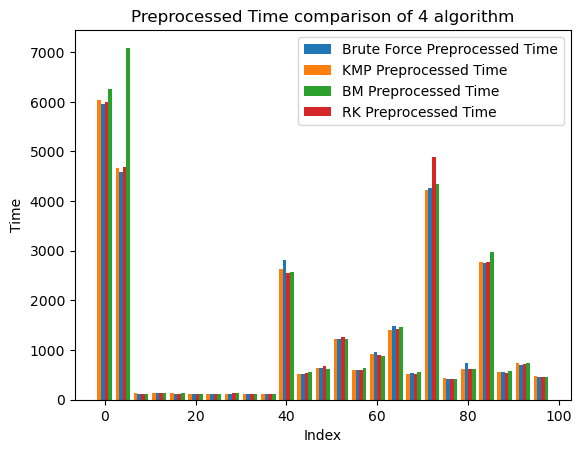

In [116]:
bin_width=0.8
plt.bar(data.index*4-bin_width/2,data['BF preprocessesed Time'], label='Brute Force Preprocessed Time')
plt.bar(data.index*4-3*bin_width/2,data['KMP preprocessesed Time'], label='KMP Preprocessed Time')
plt.bar(data.index*4+3*bin_width/2,data['BM preprocessesed Time'], label='BM Preprocessed Time')
plt.bar(data.index*4+bin_width/2,data['RK preprocessesed Time'],label="RK Preprocessed Time")


plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Preprocessed Time comparison of 4 algorithm')

plt.legend()
plt.show()

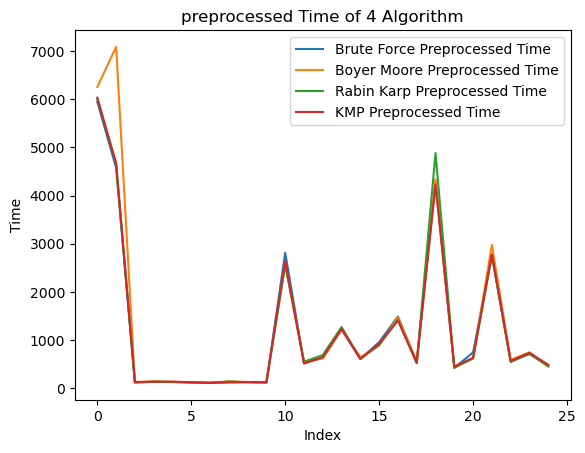

In [117]:
plt.plot(data.index,data['BF preprocessesed Time'], label='Brute Force Preprocessed Time')
plt.plot(data.index,data['BM preprocessesed Time'], label='Boyer Moore Preprocessed Time')
plt.plot(data.index,data['RK preprocessesed Time'], label='Rabin Karp Preprocessed Time')
plt.plot(data.index,data['KMP preprocessesed Time'],label="KMP Preprocessed Time")


plt.xlabel('Index')
plt.ylabel('Time')
plt.title('preprocessed Time of 4 Algorithm')

plt.legend()
plt.show()

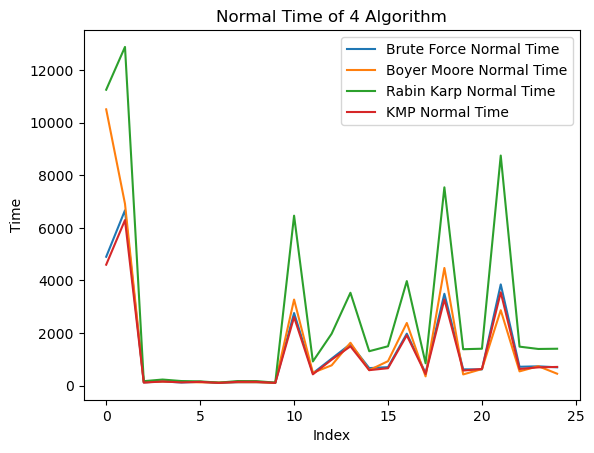

In [118]:
plt.plot(data.index,data['BF Time'], label='Brute Force Normal Time')
plt.plot(data.index,data['BM Time'], label='Boyer Moore Normal Time')
plt.plot(data.index,data['RK Time'], label='Rabin Karp Normal Time')
plt.plot(data.index,data['KMP Time'],label="KMP Normal Time")


plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Normal Time of 4 Algorithm')

plt.legend()
plt.show()

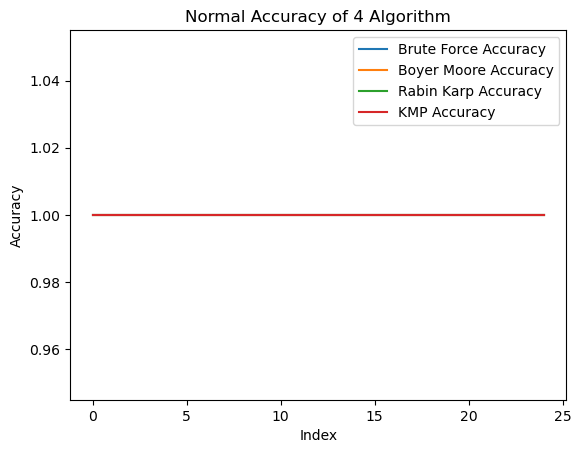

In [119]:
plt.plot(data.index,data['BF Accuracy'], label='Brute Force Accuracy')
plt.plot(data.index,data['BM Accuracy'], label='Boyer Moore Accuracy')
plt.plot(data.index,data['RK Accuracy'], label='Rabin Karp Accuracy')
plt.plot(data.index,data['KMP Accuracy'],label="KMP Accuracy")


plt.xlabel('Index')
plt.ylabel('Accuracy')
plt.title('Normal Accuracy of 4 Algorithm')

plt.legend()
plt.show()

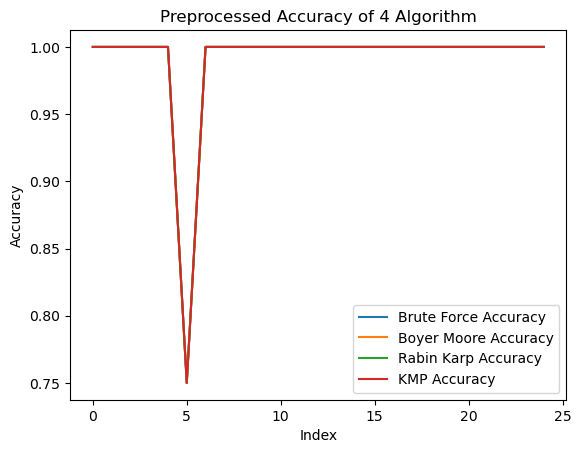

In [120]:
plt.plot(data.index,data['BF prepocessed Accuracy'], label='Brute Force Accuracy')
plt.plot(data.index,data['BM prepocessed Accuracy'], label='Boyer Moore Accuracy')
plt.plot(data.index,data['RK prepocessed Accuracy'], label='Rabin Karp Accuracy')
plt.plot(data.index,data['KMP prepocessed Accuracy'],label="KMP Accuracy")


plt.xlabel('Index')
plt.ylabel('Accuracy')
plt.title('Preprocessed Accuracy of 4 Algorithm')

plt.legend()
plt.show()

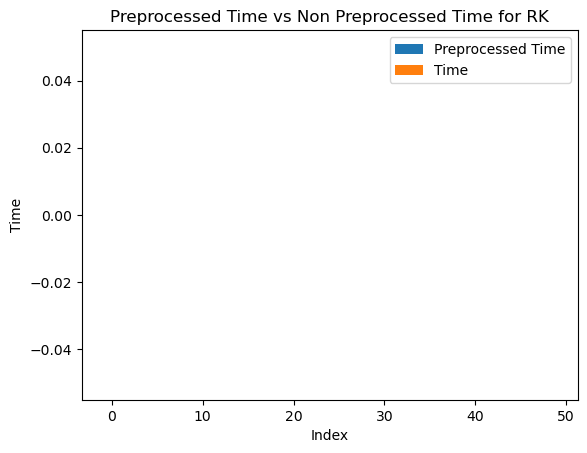

In [122]:
bin_width=0.8
plt.bar(data.index*2-bin_width/2,data['RK preprocessesed Memory'], label='Preprocessed Memory')
plt.bar(data.index*2+bin_width/2,data['RK Memory'],label="Normal memory")

plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Preprocessed vs Non Preprocessed Memory usage for RK')

plt.legend()
plt.show()

Text(0.5, 1.0, 'Preprocessed vs Non Preprocessed Memory usage for KMP')

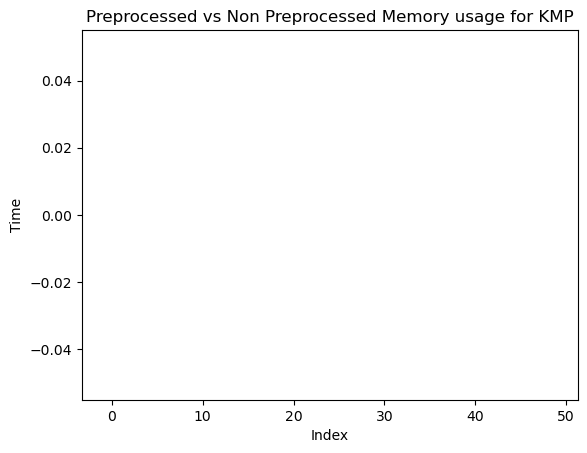

In [123]:
bin_width=0.8
plt.bar(data.index*2-bin_width/2,data['KMP preprocessesed Memory'], label='Preprocessed memory')
plt.bar(data.index*2+bin_width/2,data['KMP Memory'],label="memory")

plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Preprocessed vs Non Preprocessed Memory usage for KMP')

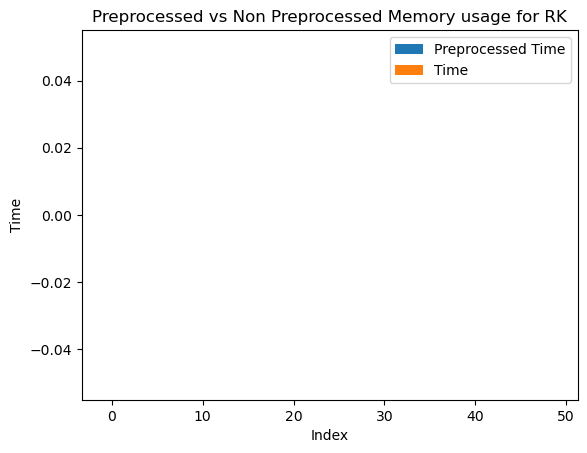

In [124]:
bin_width=0.8
plt.bar(data.index*2-bin_width/2,data['BM preprocessesed Memory'], label='Preprocessed Time')
plt.bar(data.index*2+bin_width/2,data['BM Memory'],label="Time")

plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Preprocessed vs Non Preprocessed Memory usage for RK')

plt.legend()
plt.show()

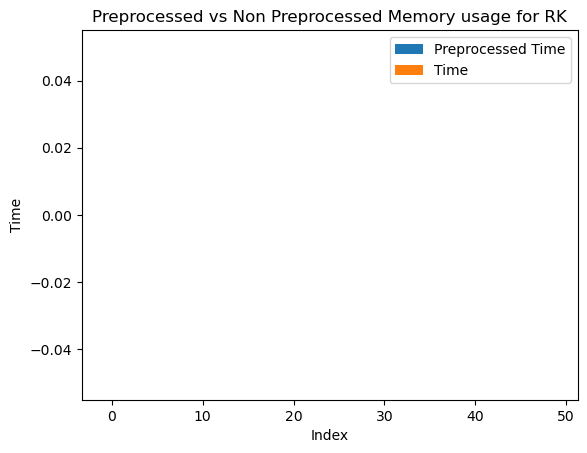

In [125]:
bin_width=0.8
plt.bar(data.index*2-bin_width/2,data['BF preprocessesed Memory'], label='Preprocessed Time')
plt.bar(data.index*2+bin_width/2,data['BF Memory'],label="Time")

plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Preprocessed vs Non Preprocessed Memory usage for RK')

plt.legend()
plt.show()

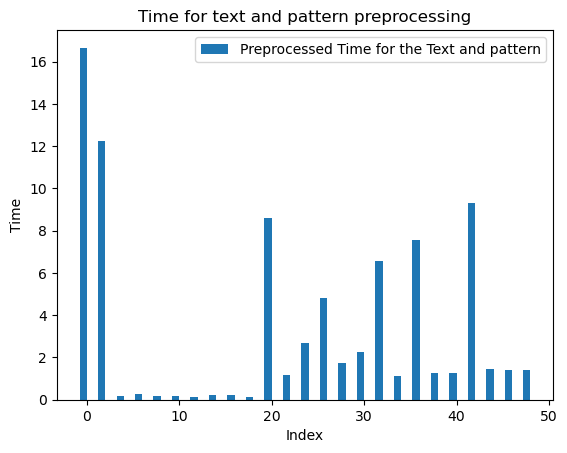

In [127]:
bin_width=0.8
plt.bar(data.index*2-bin_width/2,data['Preprocessing_times'], label='Preprocessed Time for the Text and pattern')

plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Time for text and pattern preprocessing')

plt.legend()
plt.show()

import random
data = pd.read_csv("C:/Users/DELLS/Documents/Final Year Project/data.csv")
patterns=[]
expecteds=[]

def get_random_pattern(text,pattern_length):
    start_index=random.randint(0, len(text)-pattern_length)

    pattern=text[start_index:start_index+pattern_length]

    return pattern

for _,row in data.iterrows():
    text=convert_to_text(row['File'])
    pattern=get_random_pattern(text, random.randint(4,30))

    occurances=text.count(pattern)

    patterns.append(pattern)
    expecteds.append(occurances)


data["Pattern"]=patterns
data["Expected"]=expecteds

data.to_csv("C:/Users/DELLS/Documents/Final Year Project/data1.csv", index=0)




In [ ]:
data['KMP preprocessesed Time']

    
    

0     4599.653959
1     6295.575380
2      118.645430
3      160.053492
4      126.502275
5      146.156549
6      106.655836
7      148.518324
8      148.203850
9      106.661797
10    2607.611418
11     432.623386
12     988.594294
13    1496.437073
14     591.098070
15     665.556192
16    1915.864468
17     443.267107
18    3278.119087
19     576.468945
20     636.156797
21    3548.765898
22     636.011839
23     697.044373
24     713.629007
Name: KMP Time, dtype: float64

In [140]:
data['KMP Time']

0     4599.653959
1     6295.575380
2      118.645430
3      160.053492
4      126.502275
5      146.156549
6      106.655836
7      148.518324
8      148.203850
9      106.661797
10    2607.611418
11     432.623386
12     988.594294
13    1496.437073
14     591.098070
15     665.556192
16    1915.864468
17     443.267107
18    3278.119087
19     576.468945
20     636.156797
21    3548.765898
22     636.011839
23     697.044373
24     713.629007
Name: KMP Time, dtype: float64